# Análise de dados sobre saúde do sono e estilo de vida

### Insights sobre padrões de sono e hábitos diários

# Visão geral do projeto:
O Sleep Health and Lifestyle Dataset fornece insights detalhados sobre os padrões de sono, hábitos diários e fatores de estilo de vida dos indivíduos. Essa etapa do projeto compreende dados já tratados e organizados para facilitar as análises. 

Essa análise tem como objetivo produzir insights a partir de métricas essenciais como duração do sono, qualidade do sono, níveis de atividade física, estresse, categoria de IMC, saúde cardiovascular e presença de distúrbios do sono.

# Fontes dos dados

Os dados foram obtidos no kaggle através do [link](https://www.kaggle.com/code/winterbearballu/sleep-health-and-lifestyle-eda)

Obs: este conjunto de dados é gerado sinteticamente e se destina exclusivamente a propósitos ilustrativos e educacionais. Ele visa fornecer uma estrutura realista para explorar e analisar correlações entre sono, hábitos de estilo de vida e métricas de saúde.

# Colunas do conjunto de dados:
- Gênero : Gênero do indivíduo (masculino/feminino).
- Ocupação : A profissão ou status de emprego do indivíduo (estudante, operacional, escritório e aposentado).
- Duração do sono (horas) : Total de horas de sono por dia.
- Qualidade do sono : Uma classificação subjetiva da qualidade do sono (Muito ruim, Ruim, Bom, Excelente).
- Nível de atividade física (minutos/dia) : Tempo gasto em atividade física diariamente em minutos.
- Nível de estresse : Uma classificação subjetiva do nível de estresse (Estresse elevado, Estresse moderado, Estresse muito alto, Baixo estresse).
- Categoria de IMC : Classificação do IMC do indivíduo (baixo peso, normal, sobrepeso, obeso).
- Frequência cardíaca (bpm) : frequência cardíaca em repouso em batimentos por minuto.
- Passos diários : Número de passos dados pelo indivíduo por dia.
- Distúrbio do sono : Presença de um distúrbio do sono (nenhum, insônia, apneia do sono).
- Faixa Etária: Idade do indivíduo em anos.
- Pressão arterial : Classificação da pressão arterial, mostrada em valores com base na Associação Brasileira de Cardiologia (Otima, Normal, Pre-hipertensao, Hipertensao).

# Detalhes sobre distúrbios do sono:
- Nenhum : O indivíduo não apresenta nenhum distúrbio específico do sono.
- Insônia : Caracterizada pela dificuldade de adormecer ou permanecer dormindo, muitas vezes resultando em sono inadequado.
- Apneia do sono : caracterizada por interrupções na respiração durante o sono, levando a sono interrompido e potenciais riscos à saúde.

# Importação de bibliotecas e extração da base

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import scikit_posthocs as sp

from scipy.stats import kruskal, levene, shapiro

from src.config import DADOS_TRATADOS

df_sono_parquet = pd.read_parquet(DADOS_TRATADOS)

In [8]:
# Visualização das 5 primeiras linhas

df_sono_parquet.head()

,Gênero,Ocupacao,DuracaoSono,QualidadeSono,NivelAtividadefísica,NivelEstresse,IMC,FrequenciaCardiaca,PassosDiarios,DisturbioSono,Faixa_etaria,ClassificacaoPressao
0,Masculino,Operacional,7.4,Bom,41,Estresse elevado,Obeso,91,8539,Nenhum,Jovem adulto,Normal
1,Feminino,Aposentado,4.2,Ruim,41,Estresse moderado,Obeso,81,18754,Nenhum,Adulto,Pre-hipertensao
2,Masculino,Aposentado,6.1,Ruim,107,Estresse moderado,AbaixoPeso,81,2857,Nenhum,Adulto,Normal
3,Masculino,Escritório,8.3,Excelente,20,Estresse muito alto,Obeso,55,6886,Nenhum,Jovem adulto,Normal
4,Masculino,Aposentado,9.1,Excelente,19,Estresse moderado,AcimaPeso,97,14945,Insonia,Idoso,Pre-hipertensao


# Informações da base

df_sono_parquet.info()

#### Observação: conforme apresentado acima, houve alterações de organização e limpeza:
- Dimensão: 12 colunas e 400 linhas
- Tamanho: 16.0KB (ganho de espaço)
- Ausência de valores nulos
- Alterações de formatos das colunas para formatos mais adequados

# Análise exploratória dos dados

## Classificação dos tipos de colunas em variáveis

In [13]:
colunas_numericas = df_sono_parquet.select_dtypes(include="number").columns.to_list()

colunas_numericas

['DuracaoSono', 'NivelAtividadefísica', 'FrequenciaCardiaca', 'PassosDiarios']

In [14]:
coluna_alvo = "DisturbioSono"

In [15]:
colunas_categoricas = set(df_sono_parquet.select_dtypes(include="category").columns.to_list()) - set(coluna_alvo)

colunas_categoricas.remove("DisturbioSono")

colunas_categoricas

{'ClassificacaoPressao',
 'Faixa_etaria',
 'Gênero',
 'IMC',
 'NivelEstresse',
 'Ocupacao',
 'QualidadeSono'}

# Análise exploratória dos dados

## Colunas numéricas

Para análise exploratória, podemos prosseguir a partir de perguntas para basear a nossa análise. Iniciando pelas colunas numéricas, qual a influência dessas variáveis na incidência dos distúrbios de sono?

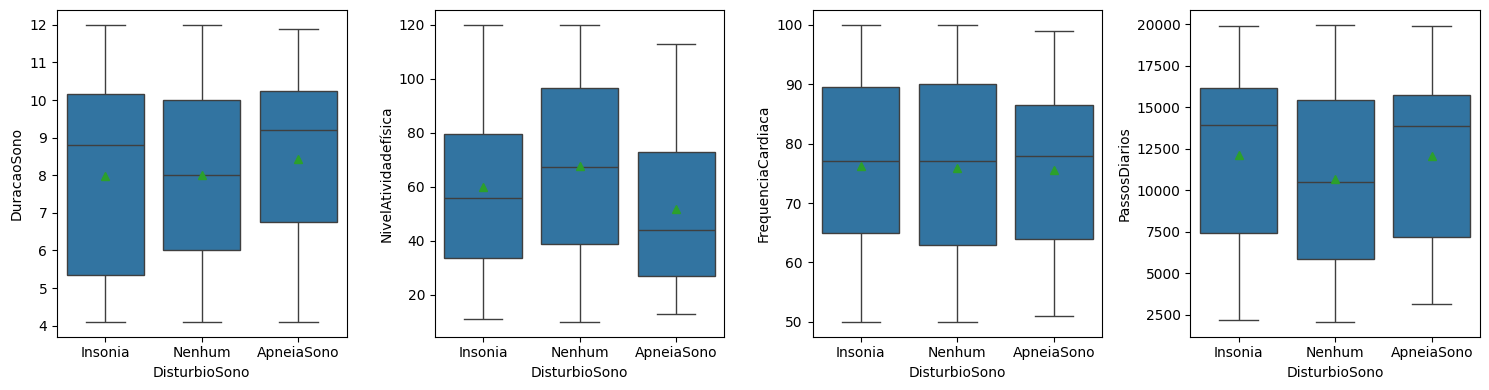

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(15,4))

for ax, coluna in zip(axs, colunas_numericas):
    sns.boxplot(data=df_sono_parquet, x=coluna_alvo, y=coluna, showmeans=True, ax=ax)

plt.tight_layout()
plt.show()

Conforme pode ser observado no boxplot, podemos notar uma tendência na diferença entre os gráficos, especialmente nas variáveis Nível de atividade física e Passos Diários, com relação a ausência ou presença dos distúrbios de sono.

Agora, precisaremos verificar se essa diferença é estatísticamente significativa.

Entretanto, para verificar essa diferença, precisamos saber qual teste estatístico usar se será um teste paramétrico ou não-paramétrico e, para isso, precisamos determinar:
- Se obedece uma distribuição normal dos dados, utilizando uma análise gráfica e o teste de Shapiro-Wilk.
- Se os dados são homogêneos, a partir do teste de Levene.

### Análise gráfica para determinar distribuição normal

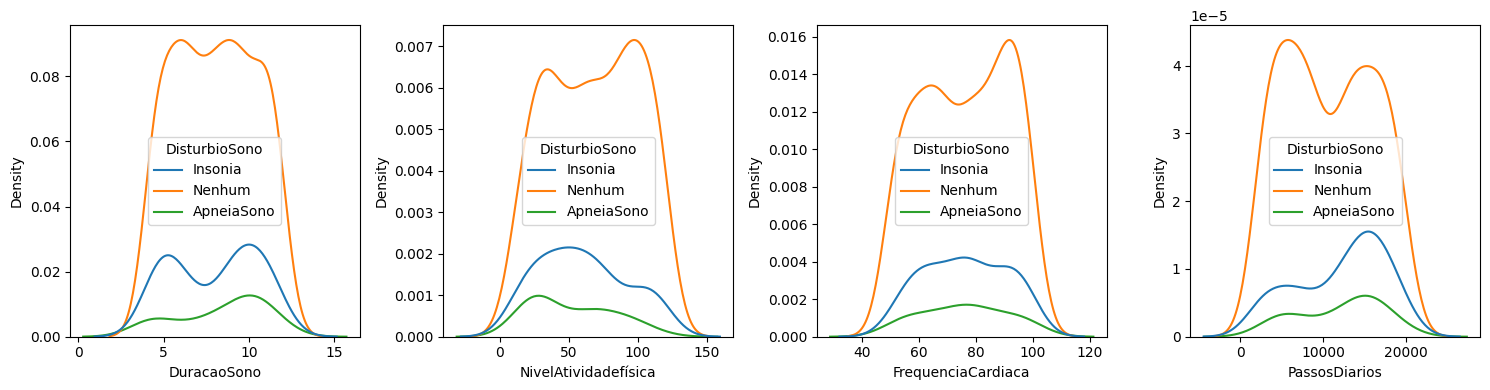

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

for ax, coluna in zip(axs, colunas_numericas):
    sns.kdeplot(data=df_sono_parquet, x=coluna, hue=coluna_alvo, ax=ax)
    
plt.tight_layout()
plt.show()

- Nesse gráfico de kde, o principal objetivo é verificar a distribuição dos dados, se representam uma curva de distribuição normal. Enquanto a altura da curva indica a quantidade de dados por disturbio de sono. 
- Conforme o observado, há mais pessoas sem nenhum disturbio de sono do que com algum tipo de problema avaliado.
- Com relação a distribuição, não é possível afirmar que se trata de uma curva de distruibuição normal, porém a distribuição gráfica permite realizarmos a análise de Shapiro-Wilk para ter certeza.

### Análise de Shapiro-Wilk

In [25]:
# Separação de valores dos disturbios relacionados as variáveis (via dictionary comprehension)

colunas_numericas_disturbios = {
    f'{coluna}_{disturbio}' : df_sono_parquet[df_sono_parquet['DisturbioSono'] == disturbio][coluna] 
    for coluna in colunas_numericas 
    for disturbio in df_sono_parquet[coluna_alvo].unique()
}

In [26]:
# Verificar se o loop funcionou, se cada chave do dicionário associou a coluna ao disturbio

colunas_numericas_disturbios.keys()

dict_keys(['DuracaoSono_Nenhum', 'DuracaoSono_Insonia', 'DuracaoSono_ApneiaSono', 'NivelAtividadefísica_Nenhum', 'NivelAtividadefísica_Insonia', 'NivelAtividadefísica_ApneiaSono', 'FrequenciaCardiaca_Nenhum', 'FrequenciaCardiaca_Insonia', 'FrequenciaCardiaca_ApneiaSono', 'PassosDiarios_Nenhum', 'PassosDiarios_Insonia', 'PassosDiarios_ApneiaSono'])

In [27]:
# Realizando a análise de normalidade para verificar se os valores obedecem uma curva de distribuição normal

analise_normalidade = {
    nome_coluna: shapiro(valores, nan_policy="omit") 
    for nome_coluna, valores in colunas_numericas_disturbios.items()
}

analise_normalidade

{'DuracaoSono_Nenhum': ShapiroResult(statistic=np.float64(0.9502953681133725), pvalue=np.float64(2.3809549194556114e-08)),
 'DuracaoSono_Insonia': ShapiroResult(statistic=np.float64(0.9098329885499705), pvalue=np.float64(3.616625978097338e-05)),
 'DuracaoSono_ApneiaSono': ShapiroResult(statistic=np.float64(0.8831217191404234), pvalue=np.float64(0.002803974456639284)),
 'NivelAtividadefísica_Nenhum': ShapiroResult(statistic=np.float64(0.9480784322477107), pvalue=np.float64(1.33166311220171e-08)),
 'NivelAtividadefísica_Insonia': ShapiroResult(statistic=np.float64(0.9526712662205302), pvalue=np.float64(0.005275702542181957)),
 'NivelAtividadefísica_ApneiaSono': ShapiroResult(statistic=np.float64(0.9131941041208197), pvalue=np.float64(0.015637535620018454)),
 'FrequenciaCardiaca_Nenhum': ShapiroResult(statistic=np.float64(0.9396643865670086), pvalue=np.float64(1.667378236914509e-09)),
 'FrequenciaCardiaca_Insonia': ShapiroResult(statistic=np.float64(0.9559531460293413), pvalue=np.float64(

In [28]:
# Melhorando a visualização da análise de normalidade

df_normalidade = pd.DataFrame(analise_normalidade, index=["Valor_estatística", "Valor_p"]).T

df_normalidade

,Valor_estatística,Valor_p
DuracaoSono_Nenhum,0.950295,2.380955e-08
DuracaoSono_Insonia,0.909833,3.616626e-05
DuracaoSono_ApneiaSono,0.883122,2.803974e-03
NivelAtividadefísica_Nenhum,0.948078,1.331663e-08
NivelAtividadefísica_Insonia,0.952671,5.275703e-03
NivelAtividadefísica_ApneiaSono,0.913194,1.563754e-02
FrequenciaCardiaca_Nenhum,0.939664,1.667378e-09
FrequenciaCardiaca_Insonia,0.955953,8.200543e-03
FrequenciaCardiaca_ApneiaSono,0.954262,2.044047e-01
PassosDiarios_Nenhum,0.941729,2.728211e-09


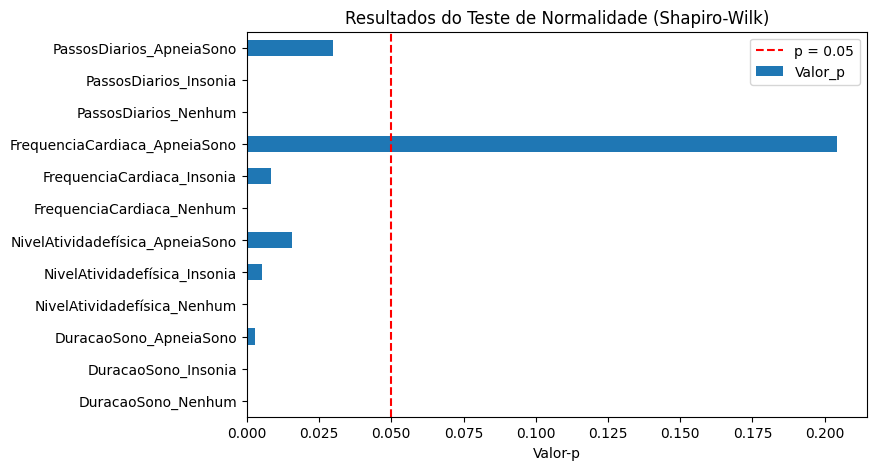

In [81]:
# Visualização gráfica dos resultados

ax = df_normalidade["Valor_p"].plot.barh(figsize=(8, 5), legend=False)
plt.axvline(x=0.05, color="red", linestyle="--", label="p = 0.05")
plt.legend()
plt.title("Resultados do Teste de Normalidade (Shapiro-Wilk)")
plt.xlabel("Valor-p");

Observação: Apenas a Frequencia Cardíaca apresentou a distribuição coindizente com um distribuição normal (p > 0.05).

### Análise de Levene

Como a análise de Levene necessita de mais uma sequência de valores, será necessário que realizemos um tratamento para que os valores de disturbio de sono sejam comparados para cada coluna numérica.

In [33]:
# Criamos a variável no qual será incluída os dados do loop

resultado_levene = {}

# Separamos os dados de distúrbio do sono para cada coluna

for coluna in colunas_numericas:
    grupo_nenhum = df_sono_parquet[df_sono_parquet['DisturbioSono'] == "Nenhum"][coluna]
    grupo_insonia = df_sono_parquet[df_sono_parquet['DisturbioSono'] == "Insonia"][coluna]
    grupo_apneia = df_sono_parquet[df_sono_parquet['DisturbioSono'] == "ApneiaSono"][coluna]

# Aplicamos o teste de Levene entre os disturbios para cada coluna em loop
    
    estatistica, valor_p = levene(grupo_nenhum, grupo_insonia, grupo_apneia, nan_policy="omit")

# Por último, inserimos o resultado na variável criada no início
    
    resultado_levene[coluna] = {"Estatística": estatistica, "Valor-p": valor_p}

resultado_levene

{'DuracaoSono': {'Estatística': np.float64(0.8230319338186035),
  'Valor-p': np.float64(0.4398461005291635)},
 'NivelAtividadefísica': {'Estatística': np.float64(0.8235649310241774),
  'Valor-p': np.float64(0.4396126940711331)},
 'FrequenciaCardiaca': {'Estatística': np.float64(1.1709328831715318),
  'Valor-p': np.float64(0.31114607161394114)},
 'PassosDiarios': {'Estatística': np.float64(1.215727389296623),
  'Valor-p': np.float64(0.29759564314133324)}}

In [34]:
# Dataframe da análise da homogeneidade

df_homogeneidade = pd.DataFrame(resultado_levene).T

df_homogeneidade

,Estatística,Valor-p
DuracaoSono,0.823032,0.439846
NivelAtividadefísica,0.823565,0.439613
FrequenciaCardiaca,1.170933,0.311146
PassosDiarios,1.215727,0.297596


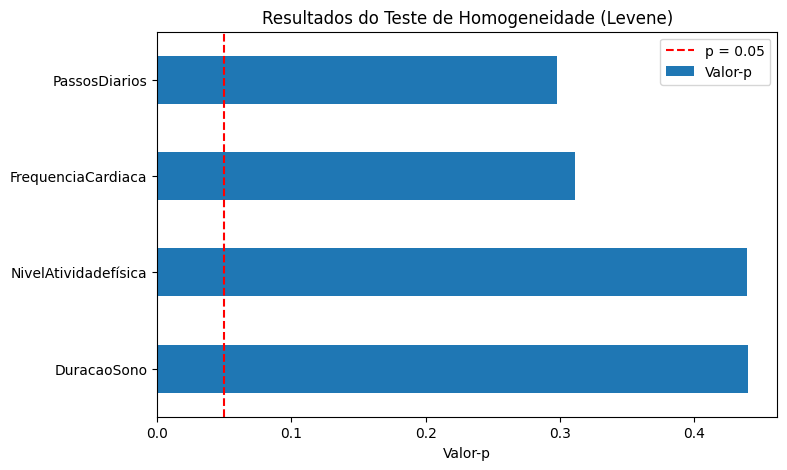

In [35]:
# Visualização gráfica dos resultados

ax = df_homogeneidade["Valor-p"].plot.barh(figsize=(8, 5), legend=False)
plt.axvline(x=0.05, color="red", linestyle="--", label="p = 0.05")
plt.legend()
plt.title("Resultados do Teste de Homogeneidade (Levene)")
plt.xlabel("Valor-p");

Observação: em todas as colunas, há pelo menos uma variância diferente, indicando uma heterogeneidade de variâncias (p > 0.05)

Até o momento, realizamos os seguintes testes:
- Shapiro-Wilk: os dados apresentaram diferença significativa (p < 0.05), indicando que não seguem uma distribuição normal, com exceção da Frequência Cardíaca (grupo ApneiaSono), que pode ser considerada uma distribuição normal.
- Levene: os dados não apresentaram diferença significativa (p > 0.05), indicando homogeneidade de variâncias.

Diante disso, é sugerido que seja realizado a análise estatística a partir de testes não-paramétricos.

### Teste de Kruskal-Wallis

O teste não-paramétrico escolhido foi de Kruskal-Wallis pois avaliaremos 3 ou mais amostras (Disturbios de sono)

In [40]:
resultado_kruskal = {}

for coluna in colunas_numericas:
    grupo_nenhum = df_sono_parquet[df_sono_parquet['DisturbioSono'] == "Nenhum"][coluna]
    grupo_insonia = df_sono_parquet[df_sono_parquet['DisturbioSono'] == "Insonia"][coluna]
    grupo_apneia = df_sono_parquet[df_sono_parquet['DisturbioSono'] == "ApneiaSono"][coluna]

    estatistica, valor_p = kruskal(grupo_nenhum, grupo_insonia, grupo_apneia, nan_policy="omit")

    resultado_kruskal[coluna] = {"Estatística": estatistica, "Valor-p": valor_p}

resultado_kruskal

{'DuracaoSono': {'Estatística': np.float64(0.7680554479393825),
  'Valor-p': np.float64(0.6811125437742669)},
 'NivelAtividadefísica': {'Estatística': np.float64(9.144845169339337),
  'Valor-p': np.float64(0.010332897053663054)},
 'FrequenciaCardiaca': {'Estatística': np.float64(0.02675563755978864),
  'Valor-p': np.float64(0.9867112665395339)},
 'PassosDiarios': {'Estatística': np.float64(5.2761135546320945),
  'Valor-p': np.float64(0.07150007521561769)}}

In [41]:
# Dataframe da análise da homogeneidade

df_kruskal = pd.DataFrame(resultado_kruskal).T

df_kruskal

,Estatística,Valor-p
DuracaoSono,0.768055,0.681113
NivelAtividadefísica,9.144845,0.010333
FrequenciaCardiaca,0.026756,0.986711
PassosDiarios,5.276114,0.071500


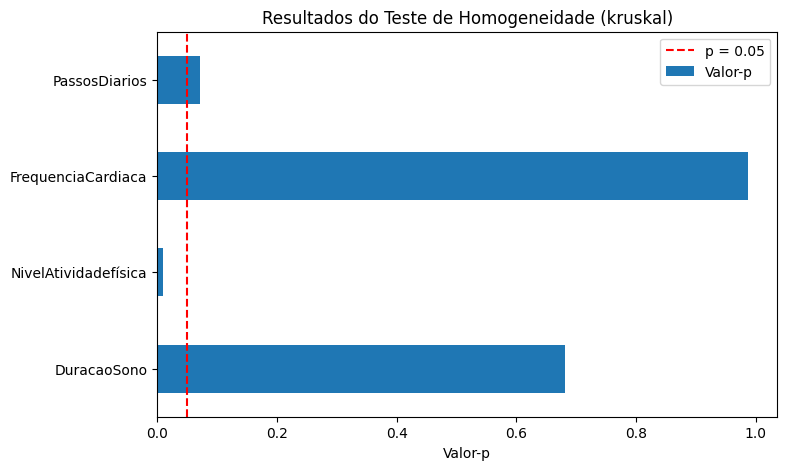

In [85]:
# Visualização gráfica dos resultados

ax = df_kruskal["Valor-p"].plot.barh(figsize=(8, 5), legend=False)
plt.axvline(x=0.05, color="red", linestyle="--", label="p = 0.05")
plt.legend()
plt.title("Resultados do Teste de Homogeneidade (kruskal)")
plt.xlabel("Valor-p");

Observação: conforme acima, apenas a variável NivelAtividadeFisica rejeita a hipótese nula (p < 0.05), indicando que existe diferença significativa entre os grupos de Distúrbio do Sono nessa variável. Ou seja, pelo menos um dos grupos se diferencia dos outros quanto ao nível de atividade física."

A partir disso, podemos concluir que **pode haver associação entre a atividade física e a presença de disturbios de sono**.

A documentação do teste de Kruskal ([link da documentação](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)), indica a realização do teste post-hoc para comparação entre os grupos de Disturbio de Sono para saber a diferença entre eles. Para isso, o escolhido foi o teste post-hoc de Dunn.

### Teste de Dunn

E um teste post-hoc não paramétrico usado após o Kruskal-Wallis, justamente para descobrir quais pares de grupos são diferentes

In [25]:
sp.posthoc_dunn(
    df_sono_parquet, 
    val_col= "NivelAtividadefísica", 
    group_col= "DisturbioSono", 
    p_adjust='bonferroni'
)

,Insonia,Nenhum,ApneiaSono
Insonia,1.000000,0.182557,0.677085
Nenhum,0.182557,1.000000,0.026548
ApneiaSono,0.677085,0.026548,1.000000


Observação: a partir do teste Post-Hoc de Dunn, observamos que há diferença significativa (p < 0.05) entre o grupo Apneia do sono e Nenhum.

Isso indica que mediante aos dados apresentados, sugere-se que **pode haver uma relação entre a prática de exercícios e a presença da Apneia do sono**

Entretanto, é necessário mais estudos para afirmar essa diferença.